<a href="https://colab.research.google.com/github/Grashch/Data-science/blob/main/Clustering_marketing_campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [228]:
data = pd.read_csv('/content/marketing_campaign.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2216 non-null   int64  
 1   ID                   2216 non-null   int64  
 2   Year_Birth           2216 non-null   int64  
 3   Education            2216 non-null   object 
 4   Marital_Status       2216 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2216 non-null   int64  
 7   Teenhome             2216 non-null   int64  
 8   Dt_Customer          2216 non-null   object 
 9   Recency              2216 non-null   int64  
 10  MntWines             2216 non-null   int64  
 11  MntFruits            2216 non-null   int64  
 12  MntMeatProducts      2216 non-null   int64  
 13  MntFishProducts      2216 non-null   int64  
 14  MntSweetProducts     2216 non-null   int64  
 15  MntGoldProds         2216 non-null   int64 

In [229]:
from datetime import datetime
data['Age'] = 2015 - data['Year_Birth']
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data['Days as a Client'] = (datetime(2015, 1, 1) - data['Dt_Customer']).dt.days
data.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Days as a Client
0,0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,...,0,0,0,0,0,3,11,1,58,849
1,1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,...,0,0,0,0,0,3,11,0,61,299
2,2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,...,0,0,0,0,0,3,11,0,50,498
3,3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,...,0,0,0,0,0,3,11,0,31,325
4,4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,...,0,0,0,0,0,3,11,0,34,347


In [230]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['Education', 'Marital_Status']

In [231]:
data['Education_encoder'] = data['Education']
encoder = LabelEncoder()
data['Education_encoder'] = encoder.fit_transform(data['Education_encoder'])

In [232]:
data['Education_encoder'].value_counts()

,count
Education_encoder,
2,1116
4,481
3,365
0,200
1,54


In [233]:
data['Marital_Status_binary'] = data['Marital_Status'].replace({
    'Married' : '1',
    'Together' : '1',
    'Single' : '0',
    'Divorced' : '0',
    'Widow' : '0',
    'Alone' : '0',
    'Absurd' : '0',
    'YOLO' : '0'
}).astype(int)

In [234]:
data['Marital_Status_binary'].value_counts()

,count
Marital_Status_binary,
1,1430
0,786


In [235]:
data['Famaly_size'] = data['Kidhome'] + data['Teenhome'] + data['Marital_Status_binary'] + 1

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Income'}>]], dtype=object)

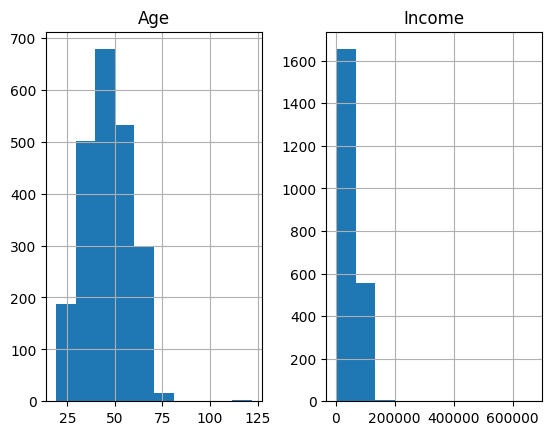

In [236]:
data_for_clustering = data.drop([
    'Marital_Status',
    'Education',
    'Dt_Customer',
    'Year_Birth',
    'ID',
    'Unnamed: 0',
    'Kidhome',
    'Teenhome',
    'Marital_Status_binary'], axis=1)
data_for_clustering[['Age', 'Income']].hist()

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Income'}>]], dtype=object)

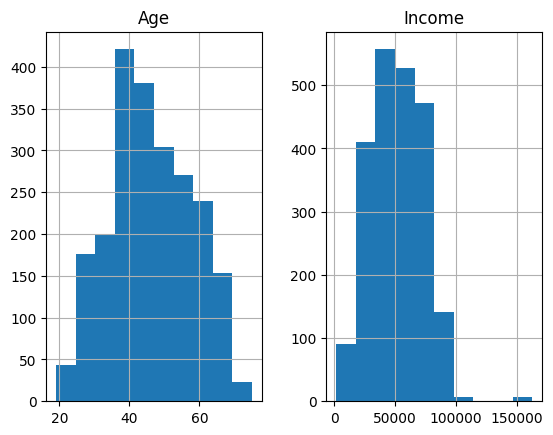

In [237]:
data_for_clustering = data_for_clustering[(data_for_clustering['Age'] < 100) & (data_for_clustering['Income'] < 500000)]
data_for_clustering[['Age', 'Income']].hist()

In [238]:
scailer = StandardScaler()
standart_data = scailer.fit_transform(data_for_clustering)
standart_data

array([[ 0.28710487,  0.31035323,  0.97765966, ...,  1.5277208 ,
        -0.35254334, -1.75835869],
       [-0.26088203, -0.38081349, -0.87261799, ..., -1.18901134,
        -0.35254334,  0.44907004],
       [ 0.9131964 , -0.79551352,  0.35793525, ..., -0.20604826,
        -0.35254334, -0.65464433],
       ...,
       [ 0.23334696,  1.45077832,  1.78715613, ..., -0.98155179,
        -0.35254334, -1.75835869],
       [ 0.80317156, -1.41756357,  0.36386563, ..., -0.97661228,
         0.53868622,  0.44907004],
       [ 0.04229031, -0.31169682, -0.65615923, ...,  1.32520077,
         1.42991579,  1.55278441]])

In [239]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(standart_data)


In [240]:
pca.explained_variance_

array([6.55216703, 1.99738524, 1.84735066])

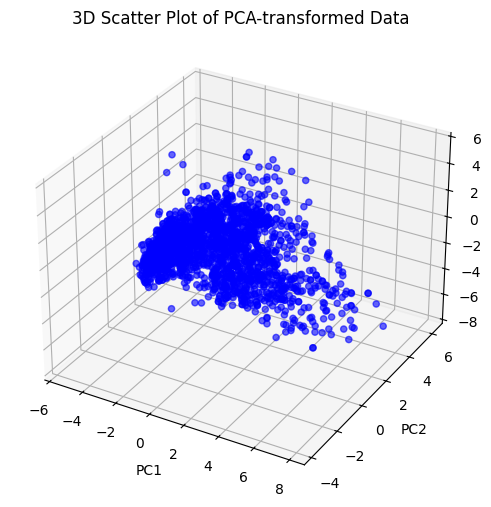

In [241]:
# Создание 3D-графика
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Указываем 3D-проекцию

# Построение точек
scatter = ax.scatter3D(
    data_pca[:, 0],    # Первый компонент (ось X)
    data_pca[:, 1],    # Второй компонент (ось Y)
    data_pca[:, 2],    # Третий компонент (ось Z)
    c='blue',          # Цвет точек
    marker='o',        # Форма маркера
    alpha=0.6         # Прозрачность (опционально)
)

# Подписи осей
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Заголовок
plt.title('3D Scatter Plot of PCA-transformed Data')

# Отображение графика
plt.show()

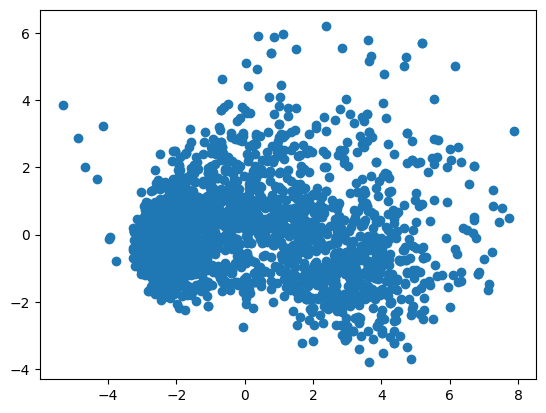

In [242]:
plt.scatter(data_pca[:,0], data_pca[:,1])

In [243]:
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(standart_data)
y_pred_kmeans = kmeans_model.predict(standart_data)
score = silhouette_score(data_pca, y_pred_kmeans)
score

np.float64(0.41196148393729426)

In [244]:
kmeans_model.cluster_centers_

array([[ 1.14259462,  0.01342437,  0.86573494,  1.10746058,  1.35438443,
         1.19729893,  1.09538861,  0.65822529, -0.53309902,  0.36688124,
         1.17357075,  0.77608583, -1.07043819,  0.03451603,  0.11161213,
         0.70387332,  0.58935543, -0.11725551, -0.01608759,  0.        ,
         0.        ,  0.36748189,  0.03182331,  0.0134351 , -0.05602523,
        -0.86003478],
       [-0.78522207,  0.00986799, -0.7825464 , -0.53672071, -0.64406266,
        -0.556768  , -0.53327286, -0.5518871 , -0.17733791, -0.72886201,
        -0.72129627, -0.80062935,  0.44186054, -0.01266052, -0.24194004,
        -0.28017547, -0.25792594, -0.11725551,  0.01807692,  0.        ,
         0.        , -0.1776931 , -0.22905469, -0.19135043, -0.124291  ,
         0.30233969],
       [ 0.26922484, -0.02690747,  0.45803756, -0.05991188, -0.11610612,
        -0.10842674, -0.06348246,  0.3211521 ,  0.75719932,  0.86373412,
         0.14031744,  0.61304859,  0.19037372, -0.03786635,  0.17966038,
       

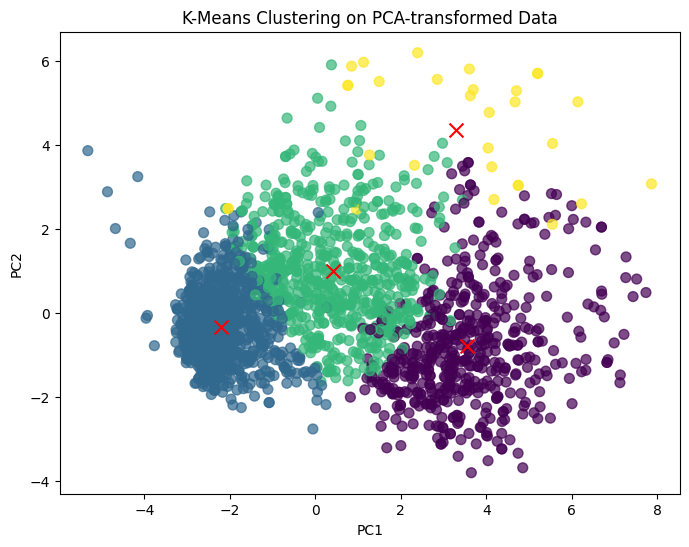

In [254]:
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:,0], data_pca[:,1], c=y_pred_kmeans, cmap='viridis', s=50, alpha=0.7)
plt.scatter(pca.transform(kmeans_model.cluster_centers_)[:,0], pca.transform(kmeans_model.cluster_centers_)[:,1],
           c='red', marker='x', s=100)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering on PCA-transformed Data')
plt.show()

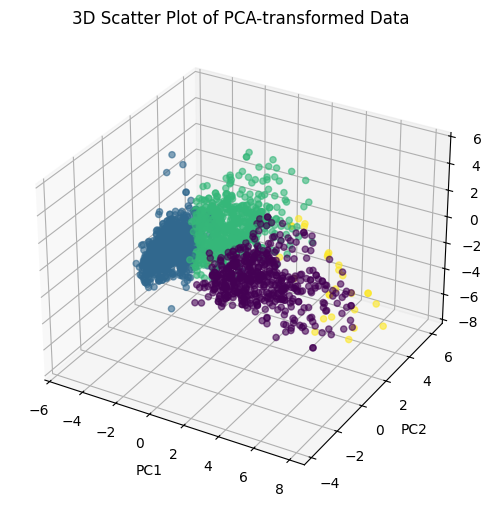

In [247]:
# Создание 3D-графика
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Указываем 3D-проекцию

# Построение точек
scatter = ax.scatter3D(
    data_pca[:, 0],    # Первый компонент (ось X)
    data_pca[:, 1],    # Второй компонент (ось Y)
    data_pca[:, 2],    # Третий компонент (ось Z)
    c=y_pred_kmeans,          # Цвет точек
    marker='o',        # Форма маркера
    alpha=0.6         # Прозрачность (опционально)
)

# Подписи осей
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Заголовок
plt.title('3D Scatter Plot of PCA-transformed Data')

# Отображение графика
plt.show()

In [248]:
data = data[(data['Age'] < 100) & (data['Income'] < 500000)]
data['Clusters'] = y_pred_kmeans
clusters = y_pred_kmeans

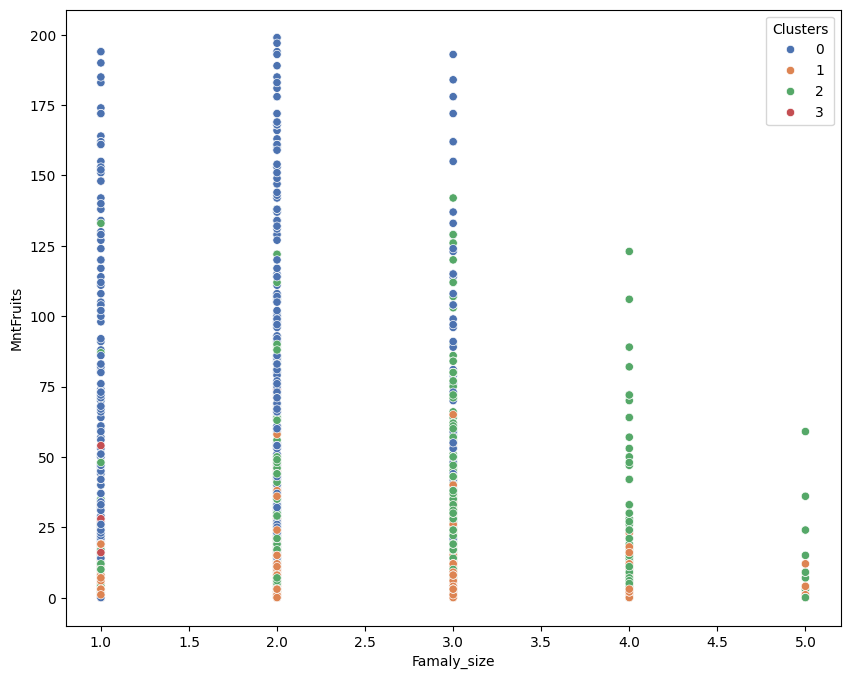

In [255]:
plt.figure(figsize=(10, 8))
pl = sns.scatterplot(data = data, x = 'Famaly_size', y = 'MntFruits', hue=data['Clusters'], palette='deep')
plt.show()
# plt.scatter(data['Income'], data['MntWines'], c=y_pred_kmeans)
